# ASSIGNMENT NO. 16 NEURAL NETWORKS (Gas Turbines)

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.constraints import maxnorm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV

In [2]:
df = pd.read_csv('gas_turbines.csv')
df

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311
...,...,...,...,...,...,...,...,...,...,...,...
15034,9.0301,1005.6,98.460,3.5421,19.164,1049.7,546.21,111.61,10.400,4.5186,79.559
15035,7.8879,1005.9,99.093,3.5059,19.414,1046.3,543.22,111.78,10.433,4.8470,79.917
15036,7.2647,1006.3,99.496,3.4770,19.530,1037.7,537.32,110.19,10.483,7.9632,90.912
15037,7.0060,1006.8,99.008,3.4486,19.377,1043.2,541.24,110.74,10.533,6.2494,93.227


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [4]:
df[df.duplicated()]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX


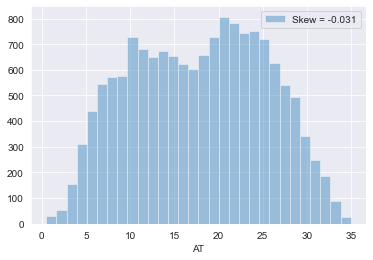

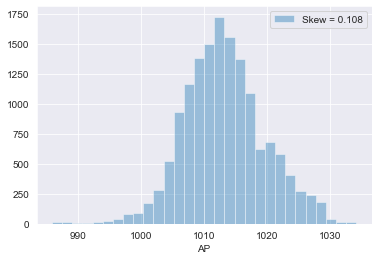

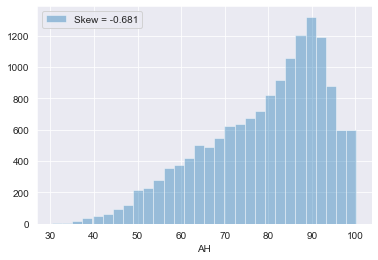

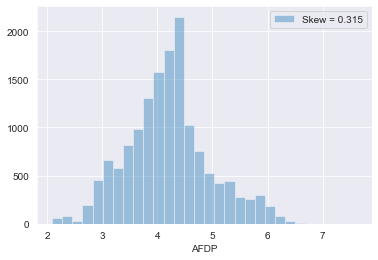

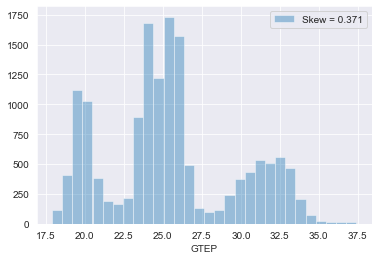

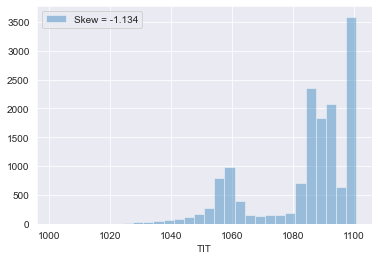

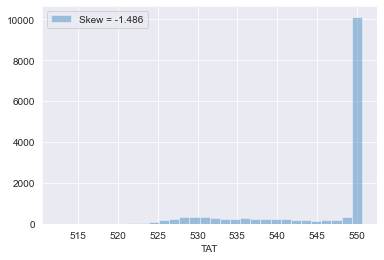

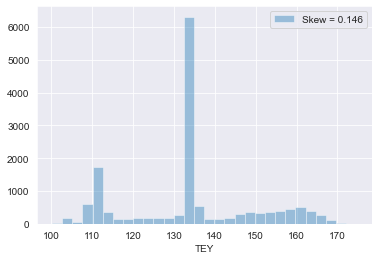

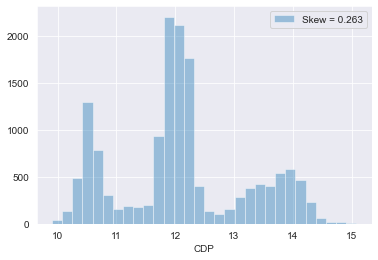

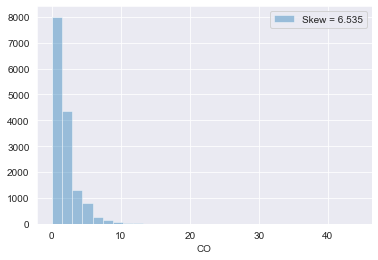

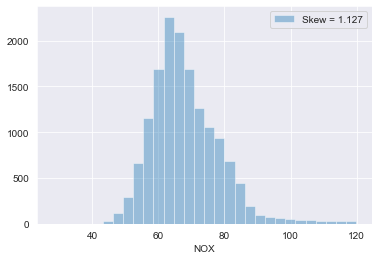

In [5]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

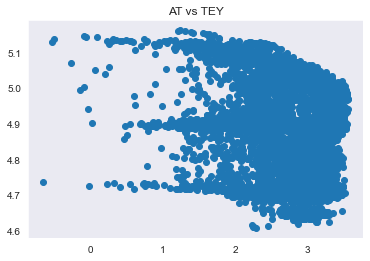

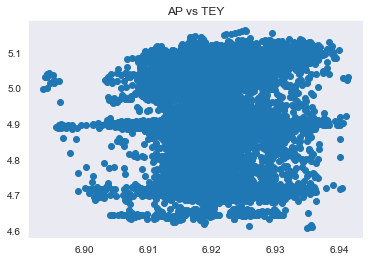

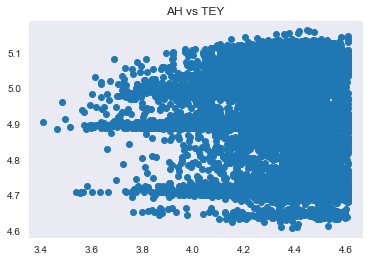

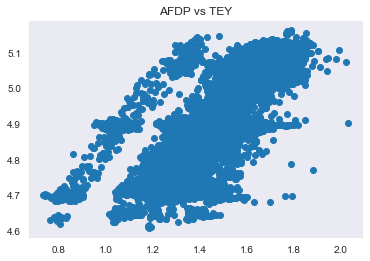

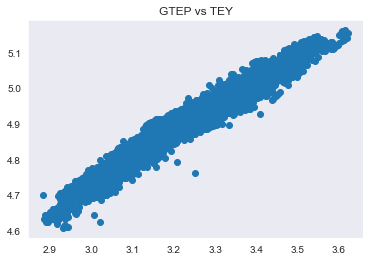

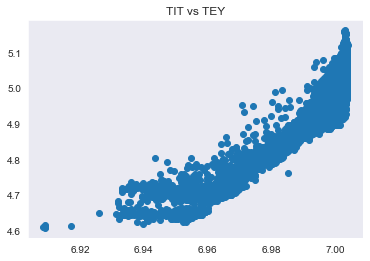

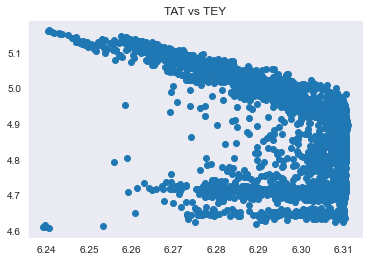

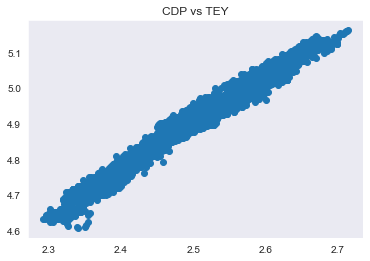

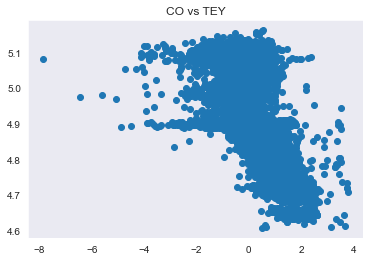

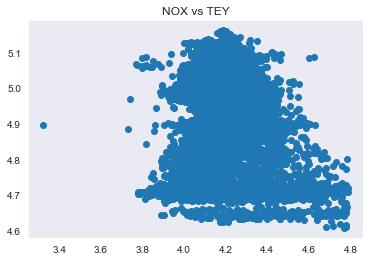

In [6]:
for i in df.columns:
    if i!="TEY": 
        plt.scatter(np.log(df[i]), np.log(df['TEY']))
        plt.title(i+ ' vs TEY')
        plt.grid()
        plt.show()

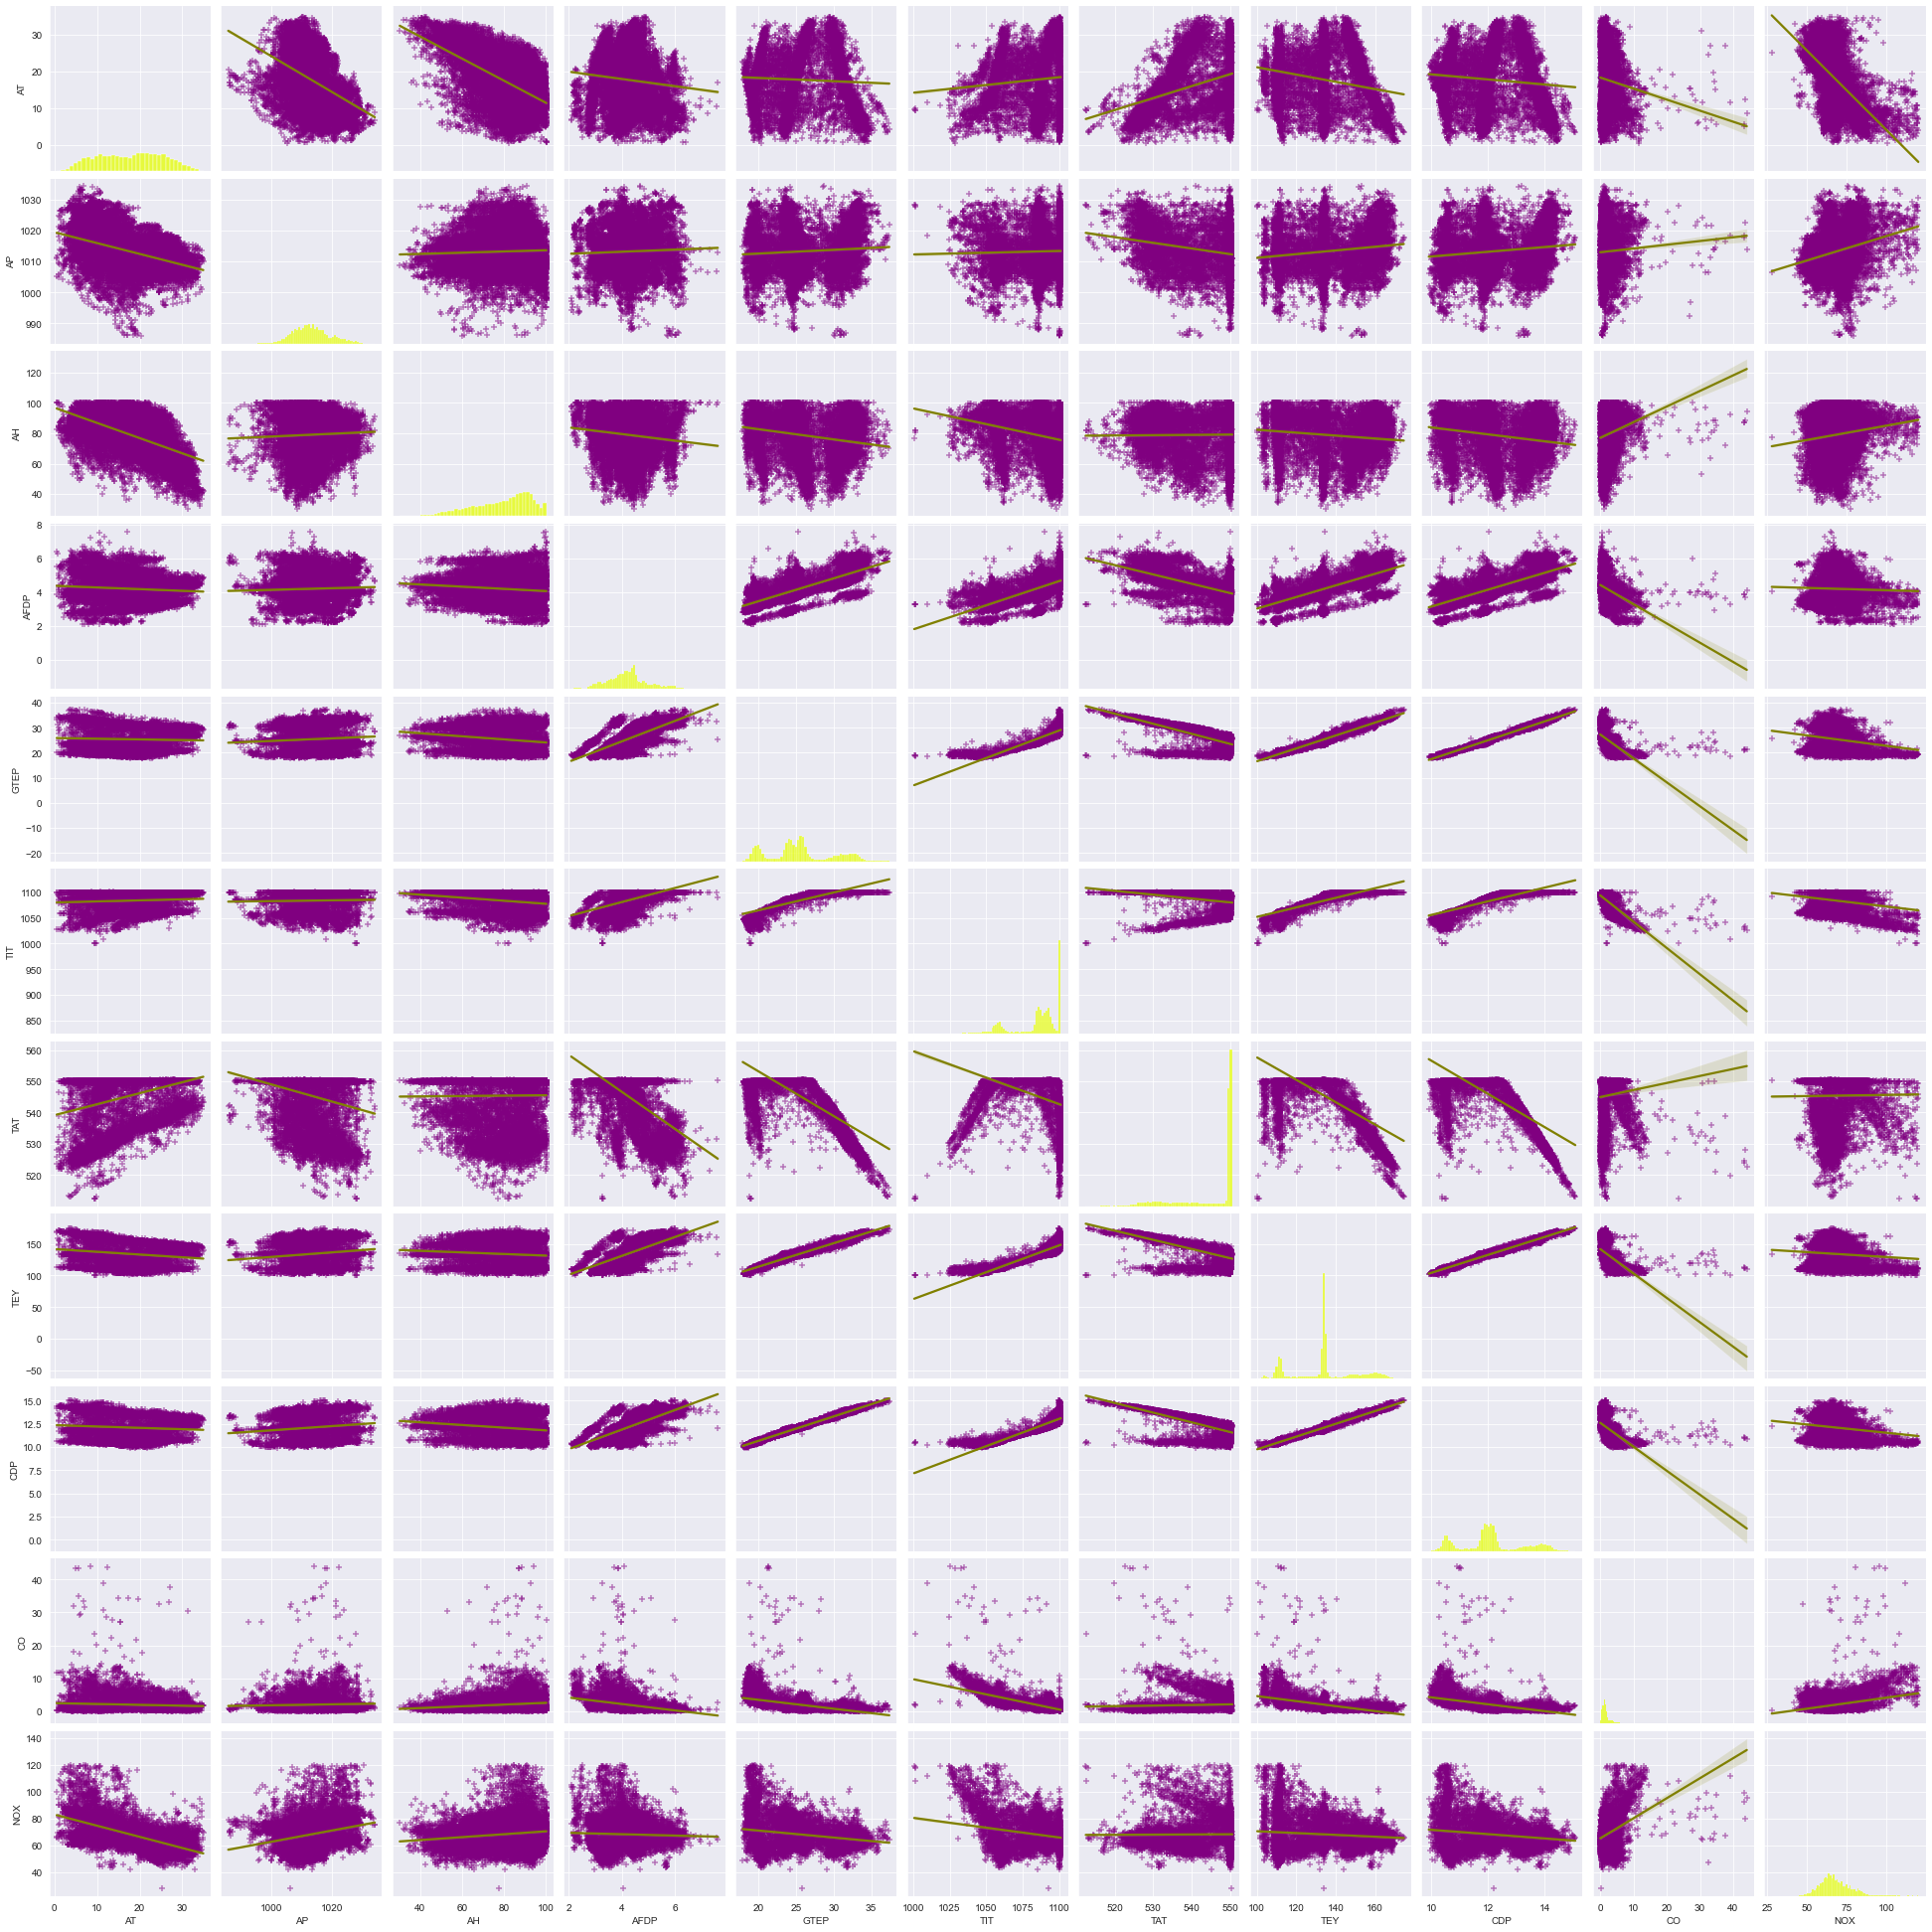

In [7]:
sns.pairplot(df,
                 markers="+",
                 kind='reg',
                 diag_kind="auto",
                 plot_kws={'line_kws':{'color':'#808000'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#800080'}},
               
                 diag_kws= {'color': '#e5ff00'})

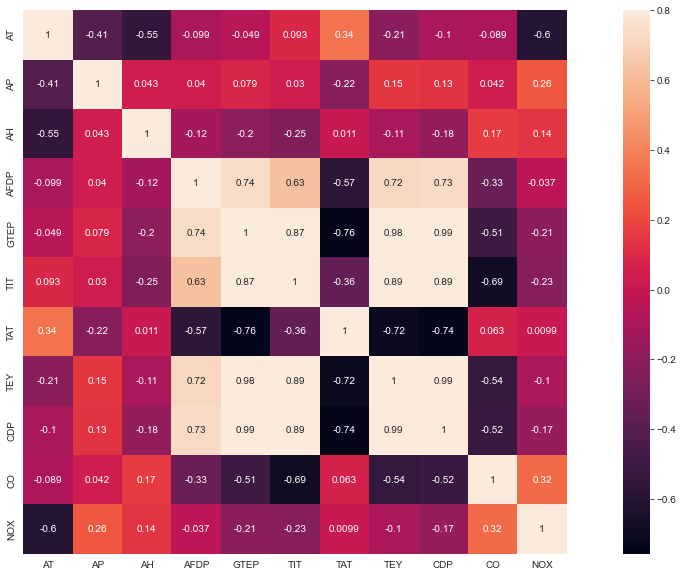

In [8]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

In [9]:
# Splitting the dataset into input & output variables
Y = df[df.columns[7]]
X = df[['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'CDP', 'CO','NOX']]

Text(0.5, 1.0, 'Correlation with Turbine energy yield \n')

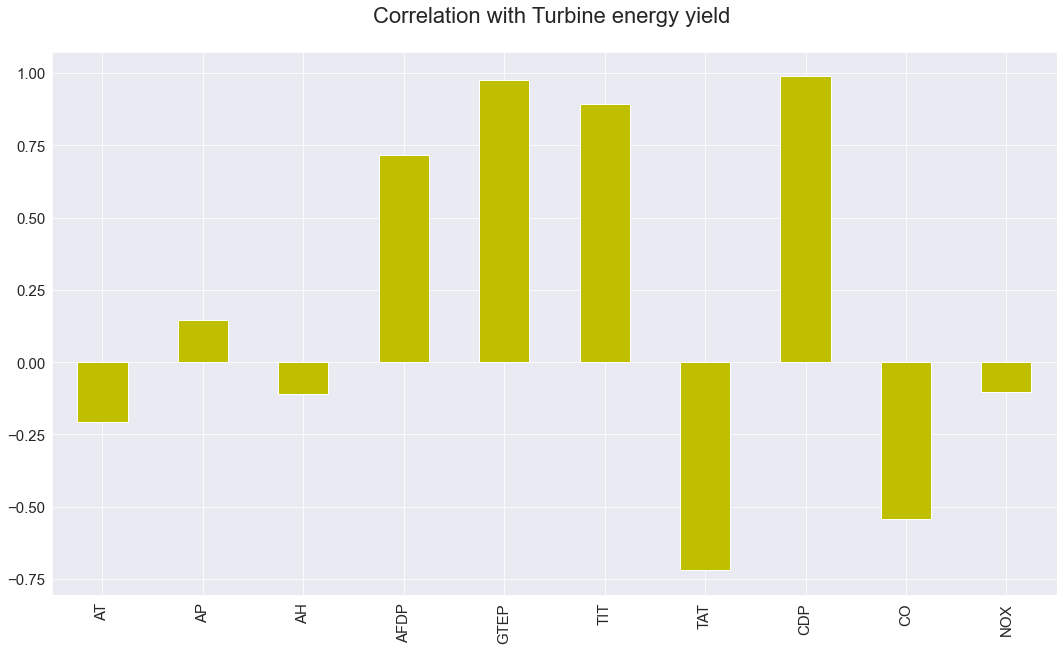

In [10]:
# Correlation with TEY

data2 = X.copy()

correlations = data2.corrwith(df["TEY"])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'y',
        rot = 90, grid = True)
plt.title('Correlation with Turbine energy yield \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

In [12]:
def select_features(X_train, y_train, X_test):
    
    # Configuring to select all features
    features = SelectKBest(score_func=mutual_info_regression, k='all')
    
    # Relationships from training data
    features.fit(X_train, y_train)
    
    # Transforming train data
    X_train_f = features.transform(X_train)
    
    # transforming test data
    X_test_f = features.transform(X_test)
    
    return X_train_f, X_test_f, features

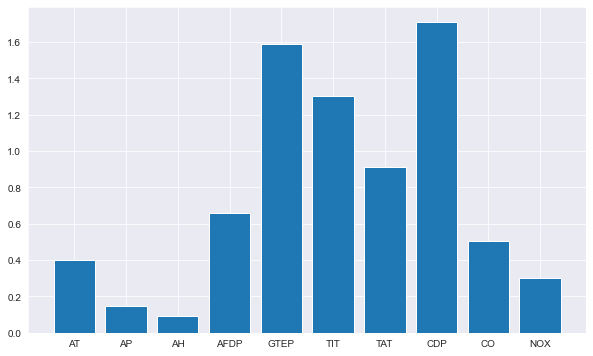

In [13]:
X_train_f, X_test_f, features = select_features(X_train, y_train, X_test)
fig, axes = plt.subplots(figsize=(10, 6))
plt.bar([i for i in range(len(features.scores_))], features.scores_)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(X.columns.values)
plt.show()

In [14]:
y_copy = df["TEY"]
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
y_ = StandardScaler().fit_transform(y_copy.values.reshape(len(y_copy),1))[:,0]


X1 = df.drop(['TEY','AT','AP','AH','CO','NOX'], axis = 1)
scaler.fit(X1)


#X_copy = X[['AFDP', 'GTEP', 'TIT', 'TAT', 'CDP']]
features_scaler=scaler.fit_transform(X1)
X_=pd.DataFrame(features_scaler,columns=X[['AFDP', 'GTEP', 'TIT', 'TAT', 'CDP']].columns)
X_.head()

,AFDP,GTEP,TIT,TAT,CDP
0,-0.921232,-1.379101,-1.488376,0.585240,-1.357331
1,-0.921495,-1.363528,-1.482325,0.585240,-1.363676
2,-0.944385,-1.351309,-1.476275,0.568715,-1.360957
3,-0.946884,-1.348194,-1.464173,0.583969,-1.356424
4,-0.924389,-1.354663,-1.458123,0.582698,-1.350985


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y_, test_size=0.3, random_state=1)

### Model

In [16]:
model = Sequential()
model.add(Dense(28, input_dim=5, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(50, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(50, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(1, kernel_initializer='uniform', activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28)                168       
                                                                 
 dense_1 (Dense)             (None, 50)                1450      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 4,219
Trainable params: 4,219
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train,y_train, epochs=500)

Epoch 1/500
329/329 [==============================] - 2s 3ms/step - loss: 0.9933 - mean_squared_error: 0.9933 - mean_absolute_error: 0.7027 - mean_absolute_percentage_error: 132.5587 - cosine_proximity: -0.0932
Epoch 2/500
329/329 [==============================] - 1s 2ms/step - loss: 0.9930 - mean_squared_error: 0.9930 - mean_absolute_error: 0.7018 - mean_absolute_percentage_error: 125.9338 - cosine_proximity: -0.0028
Epoch 3/500
329/329 [==============================] - 1s 2ms/step - loss: 0.9930 - mean_squared_error: 0.9930 - mean_absolute_error: 0.7031 - mean_absolute_percentage_error: 126.8497 - cosine_proximity: -0.1703
Epoch 4/500
329/329 [==============================] - 1s 2ms/step - loss: 0.9929 - mean_squared_error: 0.9929 - mean_absolute_error: 0.7013 - mean_absolute_percentage_error: 106.8008 - cosine_proximity: -0.0913
Epoch 5/500
329/329 [==============================] - 1s 2ms/step - loss: 0.9929 - mean_squared_error: 0.9929 - mean_absolute_error: 0.7033 - mean_abso

In [19]:
scores = model.evaluate(X_test, y_test)
print((model.metrics_names[1]))

141/141 [==============================] - 1s 2ms/step - loss: 1.0170 - mean_squared_error: 1.0170 - mean_absolute_error: 0.7207 - mean_absolute_percentage_error: 118.8821 - cosine_proximity: -0.1782
mean_squared_error


In [20]:
y2 = df["TEY"]
data_c = df.copy()
X2 = data_c.drop(['TEY','AT','AP','AH','CO','NOX'], axis = 1)

# Scaling all the features
scaler.fit(X2)
y2_ = StandardScaler().fit_transform(y2.values.reshape(len(y2),1))[:,0]



scaled_features=scaler.transform(X2)
data_head=pd.DataFrame(scaled_features,columns=X2.columns)
data_head.head()

,AFDP,GTEP,TIT,TAT,CDP
0,-0.921232,-1.379101,-1.488376,0.585240,-1.357331
1,-0.921495,-1.363528,-1.482325,0.585240,-1.363676
2,-0.944385,-1.351309,-1.476275,0.568715,-1.360957
3,-0.946884,-1.348194,-1.464173,0.583969,-1.356424
4,-0.924389,-1.354663,-1.458123,0.582698,-1.350985


In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam


x_train, x_test, y_train, y_test = train_test_split(X2, df["TEY"], test_size=0.3, random_state=42)

In [ ]:
def create_model(learning_rate,dropout_rate,activation_function,init,neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 5,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'linear'))
    
    adam=Adam(learning_rate = learning_rate)
    model.compile(loss = 'mean_squared_error',optimizer = adam, metrics = ['mse'])
    return model

# Create the model

model = KerasClassifier(build_fn = create_model,verbose = 0)

# Define the grid search parameters

batch_size = [20,40]
epochs = [100,500]
learning_rate = [0.01,0.1]
dropout_rate = [0.1,0.2]
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal']
neuron1 = [4,8,16]
neuron2 = [2,4,8]

# Make a dictionary of the grid search parameters

param_grids = dict(batch_size = batch_size,epochs = epochs,learning_rate = learning_rate,dropout_rate = dropout_rate,
                   activation_function = activation_function,init = init,neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10, scoring='neg_mean_squared_error')
grid_result = grid.fit(x_train, y_train)

# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))